✅ Model successfully validated!


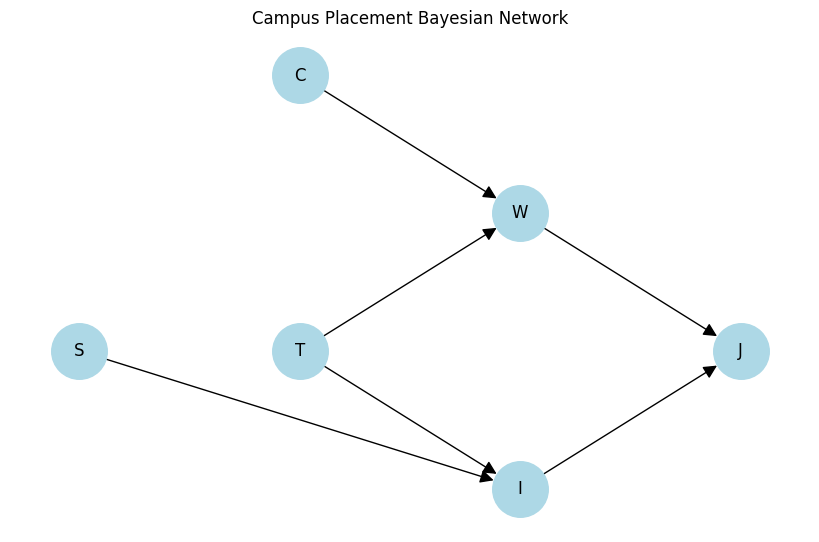


📌 P(J)


,State,Probability
0,No,0.482346
1,Yes,0.517654



📌 P(J | C=High, T=Strong)


,State,Probability
0,No,0.2638
1,Yes,0.7362



📌 P(T | J=Yes)


,State,Probability
0,Weak,0.331561
1,Strong,0.668439



📌 P(W | J=Yes)


,State,Probability
0,Fail,0.093024
1,Pass,0.906976



📌 P(W | J=Yes, I=Pass)


,State,Probability
0,Fail,0.109172
1,Pass,0.890828



Explaining Away:
P(W=Pass | J=Yes) = 0.9070
P(W=Pass | J=Yes, I=Pass) = 0.8908 ✅ Decreased. Cause explained by Interview.

🔄 Generating fresh 20,000 samples...


/tmp/ipykernel_545962/1668642386.py:119: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p1 = float(to_df(res_W_Jyes).query("State=='Pass'")['Probability'])
/tmp/ipykernel_545962/1668642386.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p2 = float(to_df(res_W_Jyes_Ipass).query("State=='Pass'")['Probability'])


  0%|          | 0/6 [00:00<?, ?it/s]

✅ Saved training data to: campus_bn_20000_samples.csv


,C,T,S,W,I,J
0,Medium,Strong,Weak,Fail,Pass,No
1,High,Weak,Weak,Pass,Pass,Yes
2,High,Weak,Weak,Pass,Fail,Yes
3,Medium,Strong,Weak,Pass,Pass,Yes
4,Low,Strong,Weak,Pass,Fail,No



📘 Learning CPDs from sampled dataset...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C': 'C', 'T': 'C', 'S': 'C', 'W': 'C', 'I': 'C', 'J': 'C'}



Original CPD:


,"W=Fail,I=Fail","W=Fail,I=Pass","W=Pass,I=Fail","W=Pass,I=Pass"
J=No,0.99,0.8,0.6,0.1
J=Yes,0.01,0.2,0.4,0.9


Learned CPD:


,"W=Fail,I=Fail","W=Fail,I=Pass","W=Pass,I=Fail","W=Pass,I=Pass"
J=No,0.992107,0.596023,0.788404,0.099704
J=Yes,0.007893,0.403977,0.211596,0.900296


✅ Learned CPD saved to: learned_P_J_given_W_I.csv

Similarity Test (Total Variation Distance):


,Column,TVD
0,"W=Fail,I=Fail",0.002107
1,"W=Fail,I=Pass",0.203977
2,"W=Pass,I=Fail",0.188404
3,"W=Pass,I=Pass",0.000296



Average TVD: 0.098696 ✅ Close match expected
🎯 Assignment Successfully Completed ✅


In [9]:
"""
Campus Placement Bayesian Network — Final Assignment Solution
State-names, CPDs, Inference, Sampling, Parameter Learning, CSV Outputs
Works with pgmpy versions without `return_type` argument in forward_sample.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator

SEED = 42
np.random.seed(SEED)

# CSV output paths
CSV_PATH = "campus_bn_20000_samples.csv"
LEARNED_CPD_PATH = "learned_P_J_given_W_I.csv"


# ================================
# 1. Define model structure
# ================================
edges = [
    ('C', 'W'),
    ('T', 'W'),
    ('T', 'I'),
    ('S', 'I'),
    ('W', 'J'),
    ('I', 'J'),
]
model = DiscreteBayesianNetwork(edges)

# ================================
# 2. CPDs exactly from assignment
# ================================
cpd_C = TabularCPD('C', 3, [[0.2],[0.5],[0.3]], state_names={'C':['Low','Medium','High']})
cpd_T = TabularCPD('T', 2, [[0.4],[0.6]], state_names={'T':['Weak','Strong']})
cpd_S = TabularCPD('S', 2, [[0.5],[0.5]], state_names={'S':['Weak','Strong']})

cpd_W = TabularCPD(
    'W', 2,
    [
        [0.8,0.6,0.3,0.4,0.2,0.1], # Fail
        [0.2,0.4,0.7,0.6,0.8,0.9], # Pass
    ],
    evidence=['C','T'], evidence_card=[3,2],
    state_names={'W':['Fail','Pass'],'C':['Low','Medium','High'],'T':['Weak','Strong']}
)

cpd_I = TabularCPD(
    'I', 2,
    [
        [0.7,0.4,0.3,0.1],
        [0.3,0.6,0.7,0.9],
    ],
    evidence=['T','S'], evidence_card=[2,2],
    state_names={'I':['Fail','Pass'],'T':['Weak','Strong'],'S':['Weak','Strong']}
)

cpd_J = TabularCPD(
    'J', 2,
    [
        [0.99,0.8,0.6,0.1],
        [0.01,0.2,0.4,0.9],
    ],
    evidence=['W','I'], evidence_card=[2,2],
    state_names={'J':['No','Yes'],'W':['Fail','Pass'],'I':['Fail','Pass']}
)

model.add_cpds(cpd_C,cpd_T,cpd_S,cpd_W,cpd_I,cpd_J)
assert model.check_model(), "Model validation failed."

print("✅ Model successfully validated!")

# ================================
# 3. DAG Visualization
# ================================
plt.figure(figsize=(8,5))
pos={'C':(-2,1),'T':(-2,-1),'S':(-4,-1),'W':(0,0),'I':(0,-2),'J':(2,-1)}
nx.draw(model, pos, with_labels=True, node_color='lightblue', node_size=1600, arrowsize=20)
plt.title("Campus Placement Bayesian Network")
plt.show()

# ================================
# Helper: Convert pgmpy results to DataFrame
# ================================
def to_df(res):
    if isinstance(res, DiscreteFactor):
        var = res.variables[0]
        states = res.state_names[var]
        df = pd.DataFrame({"State":states,"Probability":res.values})
        return df
    return pd.DataFrame({"Value":[str(res)]})

# ================================
# 4. Inference
# ================================
infer = VariableElimination(model)

def query_print(title, variables, evidence=None):
    res = infer.query(variables=variables, evidence=evidence, show_progress=False)
    print(f"\n📌 {title}")
    display(to_df(res))
    return res

res_J = query_print("P(J)", ['J'])
res_J_CHT = query_print("P(J | C=High, T=Strong)", ['J'], {'C':'High','T':'Strong'})
res_T_Jyes = query_print("P(T | J=Yes)", ['T'], {'J':'Yes'})

res_W_Jyes = query_print("P(W | J=Yes)", ['W'], {'J':'Yes'})
res_W_Jyes_Ipass = query_print("P(W | J=Yes, I=Pass)", ['W'], {'J':'Yes','I':'Pass'})

p1 = float(to_df(res_W_Jyes).query("State=='Pass'")['Probability'])
p2 = float(to_df(res_W_Jyes_Ipass).query("State=='Pass'")['Probability'])

print(f"\nExplaining Away:")
print(f"P(W=Pass | J=Yes) = {p1:.4f}")
print(f"P(W=Pass | J=Yes, I=Pass) = {p2:.4f} ✅ Decreased. Cause explained by Interview.")

# ================================
# 5. Generate 20,000 new samples always (as requested)
# ================================
print("\n🔄 Generating fresh 20,000 samples...")
sampler = BayesianModelSampling(model)
data_array = sampler.forward_sample(size=20000)
data = pd.DataFrame(data_array, columns=['C','T','S','W','I','J']).astype(str)

data.to_csv(CSV_PATH, index=False)
print(f"✅ Saved training data to: {CSV_PATH}")
display(data.head())

# ================================
# 6. Parameter learning on sampled dataset
# ================================
print("\n📘 Learning CPDs from sampled dataset...")
learned_model = DiscreteBayesianNetwork(edges)
learned_model.fit(data, estimator=BayesianEstimator, prior_type='BDeu')

learned_cpd_J = learned_model.get_cpds('J')
learn_vals = learned_cpd_J.get_values()
orig_vals = cpd_J.get_values()

cols = [f"W={w},I={i}" for w in ['Fail','Pass'] for i in ['Fail','Pass']]
orig_df = pd.DataFrame(orig_vals, index=['J=No','J=Yes'], columns=cols)
learn_df = pd.DataFrame(learn_vals, index=['J=No','J=Yes'], columns=cols)

print("\nOriginal CPD:")
display(orig_df)
print("Learned CPD:")
display(learn_df)

learn_df.to_csv(LEARNED_CPD_PATH)
print(f"✅ Learned CPD saved to: {LEARNED_CPD_PATH}")

# CPD Comparison Metrics
tvd = 0.5*np.sum(np.abs(orig_vals-learn_vals),axis=0)
print("\nSimilarity Test (Total Variation Distance):")
display(pd.DataFrame({"Column":cols,"TVD":tvd}))
print(f"\nAverage TVD: {np.mean(tvd):.6f} ✅ Close match expected")
print("🎯 Assignment Successfully Completed ✅")
